In [1]:
import os 
import napari
from tqdm import tqdm
import numpy as np
import napari
import glob2 as glob
import os
import skimage.io as io
import nd2
from skimage.morphology import label
from skimage.measure import regionprops
import zarr
from scipy.spatial import KDTree
import skimage.graph as graph
from skimage.transform import resize
import skimage as ski
import SimpleITK as sitk
import networkx as nx
import pandas as pd
from fin_morphodynamics.src.utilities.image_utils import calculate_LoG

## Load and process small test dataset

In [2]:
root = "E:\\Nick\Cole Trapnell's Lab Dropbox\\Nick Lammers\\Nick\pecfin_dynamics\\fin_morphodynamics\\"

experiment_date = "20240223"
model_name = "log-v5"
label_directory = os.path.join(root, "built_data", "cellpose_output", model_name, experiment_date, '')
data_directory = os.path.join(root, "built_data", "zarr_image_files", experiment_date, '')

# get list of images
image_list = sorted(glob.glob(data_directory + "*.zarr"))
time_int = 201
well_int = 2

# load raw data 
data_tzyx = zarr.open(image_list[well_int], mode="r")
data_zyx = np.squeeze(data_tzyx[time_int, :, :, :])

dtype = data_zyx.dtype
scale_vec = tuple([2.0, 0.55, 0.55])

# load the origianl labels and probs generated by CellPose
prob_name = experiment_date + f"_well{well_int:03}_t{time_int:03}_probs.tif"
label_name = experiment_date + f"_well{well_int:03}_t{time_int:03}_labels.tif"

prob_path = os.path.join(label_directory, prob_name)
im_prob = io.imread(prob_path)
label_path = os.path.join(label_directory, label_name)
im_label = io.imread(label_path)

# Crop to a more managable size
data_cropped = data_zyx[:, 340:590, 90:270]
labels_cropped = im_label[:, 340:590, 90:270]
probs_cropped = im_prob[:, 340:590, 90:270]

im_LoG, im_bkg = calculate_LoG(data_cropped, scale_vec, make_isotropic=True)

## Let's take a quick look at the data

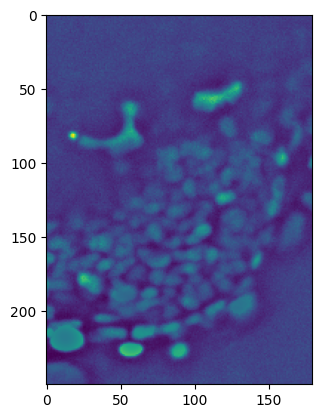

In [3]:
from matplotlib import pyplot as plt

plt.imshow(im_bkg[100])
plt.show()

## Now, let's experiment with omnipose's label stitching

In [4]:
from cellpose import models as cp_models

dim = 2 
use_GPU = True
diameter = 10
# segmentation parameters 
omni = 1
rescale = True
mask_threshold = 0 
net_avg = 0
verbose = 0 
tile = 0
compute_masks = 1
anisotropy = 1.01
flow_threshold=0.
do_3D=True
flow_factor=10
min_size=10
cellprob_threshold=0

pretrained_model = "E:\\Nick\\Cole Trapnell's Lab Dropbox\\Nick Lammers\\Nick\\pecfin_dynamics\\fin_morphodynamics\\built_data\\cellpose_training\\20240223_tdTom\\log\\models\\log-v5"

model = cp_models.CellposeModel(
                            gpu=use_GPU, pretrained_model=pretrained_model)#models.CellposeModel(gpu=use_GPU, pretrained_model=pretrained_model)

mask, flows, styles = model.eval(
            im_LoG,
            channels=[0, 0],
            do_3D=do_3D,
            min_size=min_size,
            diameter=diameter,
            anisotropy=anisotropy,
            cellprob_threshold=cellprob_threshold
        )

In [5]:
cellprob=flows[2]
bd = np.zeros_like(cellprob)
dP = flows[1]
# cellprob = np.sum([yf[k][2] for k in range(3)],axis=0)/3 if omni else np.sum([yf[k][2] for k in range(3)],axis=0)
# bd = np.sum([yf[k][3] for k in range(3)],axis=0)/3 if self.nclasses==(self.dim+2) else np.zeros_like(cellprob)
# dP = np.stack((yf[1][0] + yf[2][0], yf[0][0] + yf[2][1], yf[0][1] + yf[1][1]), axis=0)

In [6]:
import omnipose 

niter = 100
max_size=1e5
mask_threshold=0
diam_threshold=1e4
flow_threshold=1e5
flow_factor=3

masks, bounds, p, tr, affinity = omnipose.core.compute_masks(dP, cellprob, bd=bd,
                                                                                do_3D=do_3D,
                                                                                niter=niter,
                                                                                resize=None,
                                                                                min_size=min_size, 
                                                                                max_size=max_size,
                                                                                mask_threshold=mask_threshold,  
                                                                                diam_threshold=diam_threshold,
                                                                                flow_threshold=flow_threshold, 
                                                                                flow_factor=flow_factor,      
                                                                                interp=True, 
                                                                                verbose=True,
                                                                                omni=True,
                                                                                #cluster=True,
                                                                                use_gpu=use_GPU, 
                                                                                device='cuda', 
                                                                                nclasses=2, 
                                                                                dim=3)

ModuleNotFoundError: No module named 'omnipose'

### Try with boundary segmentation

In [ ]:
masks_bound, _, _, _, _ = omnipose.core.compute_masks(dP, cellprob, bd=bd,
                                                                                do_3D=do_3D,
                                                                                niter=niter,
                                                                                resize=None,
                                                                                boundary_seg=True,
                                                                                min_size=min_size, 
                                                                                max_size=max_size,
                                                                                mask_threshold=mask_threshold,  
                                                                                diam_threshold=diam_threshold,
                                                                                flow_threshold=flow_threshold, 
                                                                                flow_factor=flow_factor,      
                                                                                interp=True, 
                                                                                verbose=True,
                                                                                omni=True,
                                                                                #cluster=True,
                                                                                use_gpu=use_GPU, 
                                                                                device='cuda', 
                                                                                nclasses=2, 
                                                                                dim=3)

## Try affinity seg option

In [ ]:
mask_threshold = -12
niter = 100
max_size=1e5
diam_threshold=1e4
flow_threshold=1e5
flow_factor=3

masks_aff, _, _, _, _ = omnipose.core.compute_masks(dP, cellprob,
                                                                                do_3D=do_3D,
                                                                                niter=niter,
                                                                                resize=None,
                                                                                boundary_seg=False,
                                                                                affinity_seg=True,
                                                                                min_size=min_size, 
                                                                                max_size=max_size,
                                                                                mask_threshold=mask_threshold,  
                                                                                diam_threshold=diam_threshold,
                                                                                flow_threshold=flow_threshold, 
                                                                                flow_factor=flow_factor,      
                                                                                interp=True, 
                                                                                verbose=True,
                                                                                omni=True,
                                                                                #cluster=True,
                                                                                use_gpu=use_GPU, 
                                                                                device='cuda', 
                                                                                nclasses=2, 
                                                                                dim=3)

In [ ]:
from matplotlib import pyplot as plt
import mplcursors

fig, ax = plt.subplots()
ax.imshow(masks[70], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()

import skimage.io as io
io.imsave("test.png", masks[70].astype(np.uint16))

In [ ]:
# Boundary seg Mask version
fig, ax = plt.subplots()
z=100
ax.imshow(masks_bound[z], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()
io.imsave("test2.png", masks_bound[z].astype(np.uint16))

In [ ]:
fig, ax = plt.subplots()
z = 100
ax.imshow(masks_aff[z], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()
io.imsave("test3.png", masks_aff[z].astype(np.uint16))

In [ ]:
fig, ax = plt.subplots()
ax.imshow(mask[100], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()

In [ ]:
plt.imshow(mask[70], cmap="Set3", interpolation='none')
plt.show()

In [ ]:
print(len(np.unique(mask)))
print(len(np.unique(masks)))

In [ ]:
omni = 1
rescale = False
mask_threshold = 0 
net_avg = 0
verbose = 0 
tile = 0
compute_masks = 1
rescale = None
flow_threshold=0.
do_3D=True
flow_factor=10

masks_cp, flows_cp, _ = model.eval(im_LoG,
                                   channels=[0],
                                   rescale=rescale,
                                   mask_threshold=mask_threshold,
                                   net_avg=net_avg,
                                   transparency=True, 
                                   flow_threshold=flow_threshold,
                                   verbose=verbose, 
                                   tile=tile,
                                   compute_masks=compute_masks, 
                                   do_3D=True, 
                                   omni=omni,
                                   flow_factor=flow_factor)